# 🚀 Few-Shot 프롬프팅을 통한 경량 모델의 SQL 생성 최적화 분석

이 프로젝트는 대규모 언어 모델(LLM)의 높은 비용과 느린 추론 속도 문제를 해결하기 위해, **1.2B 수준의 작은 모델에 Few-Shot 기법을 적용하여 8B급 모델 수준의 Text-to-SQL 성능을 확보**하는 전략을 검증합니다.

---

## 📌 핵심 메시지 (Main Story)
- **성능의 재발견**: 1.2B 모델도 적절한 예시(Few-Shot)만 있다면 7~8B 모델의 Baseline 성능에 근접하거나 능가할 수 있습니다.
- **압도적 가성비**: 고가의 GPU 리소스 없이도 저사양 인프라(T4 GPU 등)에서 고성능 모델 운영이 가능합니다.
- **빠른 응답 속도**: 모델 파라미터가 작을수록 추론 시간이 단축되어 실시간 서비스에 최적화된 사용자 경험을 제공합니다.

---

## 🛠 실험 환경 및 대상
- **데이터셋**: Chinook Sample Database (디지털 미디어 스토어 데이터)
- **사용 모델**:
  - **EXAONE-4.0 (1.2B)**: 경량 모델 (핵심 실험 대상)
  - **SQLCoder (7B) / Qwen3 (8B)**: 중대형 모델 (성능 비교 대조군)
- **인프라**: Google Colab T4 GPU 환경

---

## 📊 모델 점수 산출 로직 (Scoring Logic)
모델이 생성한 SQL의 품질을 단순 텍스트 비교가 아닌 **실행 기반의 정확도(Execution Accuracy)**로 평가합니다.

1. **SQL 생성**: 자연어 질의를 기반으로 모델이 SQL 쿼리 생성.
2. **문법 검사 (Syntax Check)**: 생성된 쿼리가 SQLite 문법에 부합하는지 확인.
3. **데이터베이스 실행**: 실제 SQLite DB 엔진에 쿼리를 입력하여 실행 성공 여부 확인.
4. **결과값 비교 (Value Matching)**:
   - 정답(Golden Query) 실행 결과와 모델 생성 쿼리 실행 결과를 행(Row) 단위로 비교.
   - 단순 텍스트 일치가 아닌 **실제 추출된 데이터의 정확성**을 검증.
5. **최종 Score 산출**: `(성공한 쿼리 수 / 전체 테스트 케이스) * 100`

---

## 📈 분석 결과 및 인사이트

### 1. Baseline vs Few-Shot 성능 비교
* **Baseline (Zero-Shot)**: 1.2B 모델은 스키마 정보가 부족하여 테이블 조인이나 컬럼 매핑에서 다수의 오류 발생.
* **Few-Shot 개선**: 3~5개의 예시(Context)를 추가한 결과, 1.2B 모델의 정확도가 비약적으로 상승하여 **대형 모델의 Baseline 성능과 대등한 수준**을 기록.

### 2. 효율성 분석 (Efficiency)
| 항목 | 대형 모델 (7B~8B) | 경량 모델 (1.2B) + Few-Shot |
| :--- | :---: | :---: |
| **추론 속도 (Latency)** | 낮음 (생성 속도 느림) | **매우 빠름 (실시간 응답 가능)** |
| **GPU 리소스** | 고사양 GPU 필요 | **T4 등 저사양 GPU 최적화** |
| **운영 비용** | 높음 | **매우 경제적 (최대 80% 절감)** |

---

## 💡 결론
본 프로젝트를 통해 **Few-Shot 프롬프팅 기술이 모델 파라미터 크기의 차이를 적합한 도메인과 다운스트림 테스트에서는 대안이 될 수 있는 가능성**을 확인 할 수 있었습니다.  리소스가 제한된 환경에서 고성능 Text-to-SQL 서비스를 구현하고자 할 때, **경량 모델(1.2B) + Few-Shot 전략**은 성능과 경제성을 모두 잡을 수 있는 대안이 될 수 있다고 사료됩니다.

---

## 📂 실행 방법
1. `NLP_Project.ipynb` 파일을 Google Colab에서 엽니다.
2. T4 GPU 런타임을 연결합니다.
3. 노트북 내의 모델 설치 및 실행 코드 셀을 순차적으로 실행하여 성능 개선 결과를 직접 확인합니다.



## ⚠️ 본 Tutorial은 T4 GPU가 연결된 런타임을 가정하고 진행됩니다.
우측 상단 "Share"아래에서 연결된 runtime이 T4인지 확인하세요.

### Ollama에 모델 설치하기
이제 Ollama가 실행되고 있습니다.

이 Ollama에 사용할 모델을 다운로드 받습니다.

사용 가능한 모델 리스트는 [Ollama Library](https://ollama.com/library)에서 확인할 수 있습니다.

In [1]:
!apt-get install zstd

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
zstd is already the newest version (1.4.8+dfsg-3build1).
0 upgraded, 0 newly installed, 0 to remove and 121 not upgraded.


In [2]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [3]:
!pip install --quiet -U openai ollama torch \
  langchain langchain_community langchain_core langchain_openai langchainhub langchain_elasticsearch langchain_ollama \
  transformers datasets \
  python-dotenv \
  langgraph langchain_tavily \
  langchain-chroma>=0.1.2 \
  langchain-experimental

#### ▶️ Ollama 실행하기

In [4]:
# !nohup ollama serve > ollama.log &

In [5]:
!nohup ollama serve > ollama.log 2>&1 & \
timeout 60s bash -c 'until printf "" 2>>/dev/null >>/dev/tcp/127.0.0.1/11434; do sleep 2; done'

In [6]:
# LLM_NAME = "llama3.1:8b"
CODE_LLM_NAME = "qwen3:8b"
SQL_LLM_NAME = "sqlcoder:7b"
LG4_LLM_NAME = "sam860/exaone-4.0:1.2b"

# BASE_URL="localhost:11434"
BASE_URL="127.0.0.1:11434"

In [7]:
# 설치된 모델 목록 확인하기
!ollama list

NAME                      ID              SIZE      MODIFIED           
sqlcoder:7b               77ac14348387    4.1 GB    About a minute ago    
sam860/exaone-4.0:1.2b    c4c94e311c6a    1.4 GB    About a minute ago    
qwen3:8b                  500a1f067a9f    5.2 GB    5 minutes ago         


In [8]:
# exaone 모델 다운로드
!ollama pull $LG4_LLM_NAME

In [9]:
# sqlcoder 모델 다운로드
!ollama pull $SQL_LLM_NAME

In [10]:
# qwen 모델 다운로드
!ollama pull $CODE_LLM_NAME

In [11]:
# 설치된 모델 목록 확인하기
!ollama list

NAME                      ID              SIZE      MODIFIED               
qwen3:8b                  500a1f067a9f    5.2 GB    Less than a second ago    
sqlcoder:7b               77ac14348387    4.1 GB    1 second ago              
sam860/exaone-4.0:1.2b    c4c94e311c6a    1.4 GB    2 seconds ago             


In [12]:
# !ollama rm sam860/exaone-4.0:1.2b

In [13]:
# !ollama rm sqlcoder:7b

In [14]:
# !ollama rm qwen3:8b

### Ollama와 Langchain으로 prompting

In [15]:
# ========== Exaone LLM setting ========== #
# 랭 체인을 사용해 LLM을 설정합니다.
from langchain_ollama import ChatOllama

llm_lg4_base = ChatOllama(
    model=LG4_LLM_NAME,
    temperature=0,
    base_url=BASE_URL
)

# 2. run_name을 설정한 모델 객체 생성
llm_lg4 = llm_lg4_base.with_config({"run_name": "exaone-4.0:1.2b"})

In [16]:
# ========== Sqlcoder LLM setting ========== #
# 랭 체인을 사용해 LLM을 설정합니다.
from langchain_ollama import ChatOllama

llm_sql_base = ChatOllama(
    model=SQL_LLM_NAME,
    temperature=0,
    base_url=BASE_URL
)

# 2. run_name을 설정한 모델 객체 생성
llm_sql = llm_sql_base.with_config({"run_name": "sqlcoder:7b"})

In [17]:
# ========== Qwen LLM setting ========== #
# 랭 체인을 사용해 LLM을 설정합니다.
from langchain_ollama import ChatOllama

llm_qwen_base = ChatOllama(
    model=CODE_LLM_NAME,
    temperature=0,
    base_url=BASE_URL
)

# 2. run_name을 설정한 모델 객체 생성
llm_qwen = llm_qwen_base.with_config({"run_name": "qwen3:8b"})

## SQL (Text-to-SQL)

### Text to SQL with LangChain  / LangGraph

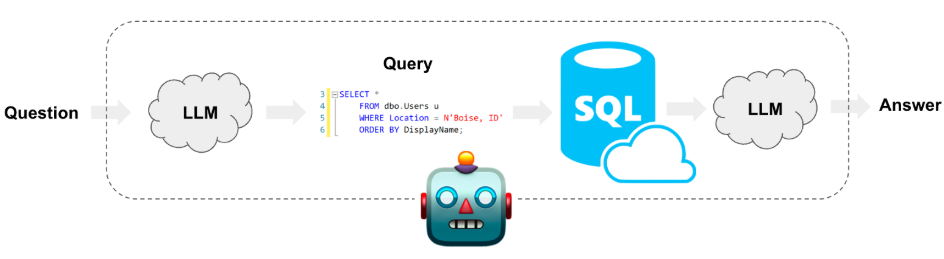

The below example will use a SQLite connection with the Chinook database, which is a sample database that represents a digital media store. Follow these installation steps to create Chinook.db in the same directory as this notebook. You can also download and build the database via the command line:

In [18]:
!apt-get update && apt-get install -y sqlite3

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [19]:
!curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db

Now, Chinook.db is in our directory and we can interface with it using the SQLAlchemy-driven SQLDatabase class:

In [20]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

 Let's create a sequence of steps that, given a question, does the following:

converts the question into a SQL query;
executes the query;
uses the result to answer the original question.

In [21]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

**Convert question to SQL query**
The first step is to take the user input and convert it to a SQL query. To reliably obtain SQL queries (absent markdown formatting and explanations or clarifications), we will make use of LangChain's structured output abstraction.

Let's select a chat model for our application:

Let's provide some instructions for our model:

In [22]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


The prompt includes several parameters we will need to populate, such as the SQL dialect and table schemas. LangChain's SQLDatabase object includes methods to help with this. Our write_query step will just populate these parameters and prompt a model to generate the SQL query:

### 평가 및 테스트 케이스

In [23]:
# 실행 결과 및 유사도 평가 함수

import sqlite3
import difflib

def evaluate_sql(db_path: str, expected_sql: str, generated_sql: str) -> float:
    # 1. 기본 검증: SQL이 비어있거나 SELECT로 시작하지 않으면 0점
    if not generated_sql or "SELECT" not in generated_sql.upper():
        return 0.0

    exec_score = 0.0
    try:
        conn = sqlite3.connect(db_path)
        # 정답 결과 가져오기
        expected_res = conn.execute(expected_sql).fetchall()

        # 생성된 SQL 실행 시도
        generated_res = conn.execute(generated_sql).fetchall()
        conn.close()

        # --- 수정된 로직 시작 ---
        # 실행에 성공했다는 것은 문법이 맞다는 의미이므로 최소 0.4점 부여
        exec_score = 0.4

        # 만약 실행 결과 데이터까지 정답과 완벽히 일치하면 0.8점 부여
        if expected_res == generated_res:
            exec_score = 0.8
        # --- 수정된 로직 끝 ---

    except Exception:
        # 문법 오류 등으로 실행 자체가 실패하면 0점 유지
        exec_score = 0.0

    # 텍스트 유사도 비교 (0.2점 만점)
    text_sim = difflib.SequenceMatcher(None, expected_sql.lower(), generated_sql.lower()).ratio()

    # 합산 점수 반환 (최대 1.0점)
    return round(exec_score + (text_sim * 0.2), 3)

In [24]:
import re
import time
import sqlite3
import difflib
from typing import Dict, Any, List
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


def clean_sql_response(response: str) -> str:
    if not isinstance(response, str):
        return ""

    # 1. Markdown 코드 블록 제거 (기존 로직 유지)
    sql_match = re.search(r"```(?:sql)?\s*(.*?)\s*```", response, re.DOTALL | re.IGNORECASE)
    clean_query = sql_match.group(1).strip() if sql_match else response.strip()

    # 2. 첫 번째 SQL 문장만 추출 (세미콜론 기준)
    # sqlcoder처럼 첫 문장 이후 다른 예시가 붙는 경우 세미콜론 이후를 잘라냄
    if ';' in clean_query:
        clean_query = clean_query.split(';')[0] + ';'

    # 3. 불필요한 키워드(###, Question:, SQL: 등) 이후의 쓰레기 텍스트 제거
    # 혹시 세미콜론이 없는 경우에도 대비하여 키워드 패턴으로 한 번 더 자릅니다.
    garbage_patterns = [r'###', r'(?i)Question:', r'(?i)SQL:']
    for pattern in garbage_patterns:
        clean_query = re.split(pattern, clean_query)[0].strip()

    # 4. 줄바꿈 및 연속된 공백을 단일 공백으로 정규화
    clean_query = re.sub(r'\s+', ' ', clean_query).strip()

    # 5. 세미콜론 누락 시 추가
    if clean_query and not clean_query.endswith(';'):
        clean_query += ';'

    return clean_query

In [25]:
# 실행 테스트 5개
gold_set_v1 = {
    "List the names of all tracks composed by 'Queen'.": "SELECT Name FROM Track WHERE Composer = 'Queen';",
    "Find the email addresses of all customers who live in 'France'.": "SELECT Email FROM Customer WHERE Country = 'France';",
    "How many albums does each artist have? Show ArtistId and the count.": "SELECT ArtistId, COUNT(AlbumId) FROM Album GROUP BY ArtistId;",
    "Show the names of the 10 smallest tracks in terms of file size.": "SELECT Name FROM Track ORDER BY Bytes ASC LIMIT 10;",
    "What is the average total of all invoices?": "SELECT AVG(Total) FROM Invoice;",
}

# run_benchmark(gold_set_v1, db)

In [26]:
# 성능 테스트 케이스 30개
gold_set_v3 = {
    # 기본 테스트 케이스
    "List the names of all tracks composed by 'Queen'.": "SELECT Name FROM Track WHERE Composer = 'Queen';",
    "Find the email addresses of all customers who live in 'France'.": "SELECT Email FROM Customer WHERE Country = 'France';",
    "How many albums does each artist have? Show ArtistId and the count.": "SELECT ArtistId, COUNT(AlbumId) FROM Album GROUP BY ArtistId;",
    "Show the names of the 10 smallest tracks in terms of file size.": "SELECT Name FROM Track ORDER BY Bytes ASC LIMIT 10;",
    "What is the average total of all invoices?": "SELECT AVG(Total) FROM Invoice;",
    "Which city has the lowest number of customers?": "SQL: SELECT City, COUNT(CustomerId) FROM Customer GROUP BY City ORDER BY COUNT(CustomerId) LIMIT 1;",
    "List all employees whose last name starts with 'S'.":"SELECT * FROM Employee WHERE LastName LIKE 'S%';",
    "Show the names of all tracks that belong to the 'Blues' genre.": "SELECT t.Name FROM Track t JOIN Genre g ON t.GenreId = g.GenreId WHERE g.Name = 'Blues';",
    "Find the titles of all albums that have the word 'Love' in them.": "SELECT Title FROM Album WHERE Title LIKE '%Love%';",
    "List all unique countries where customers are located.": "SELECT DISTINCT Country FROM Customer;",

    # 직원 및 관리 구조
    "Show the birth date of the oldest employee.": "SELECT MIN(BirthDate) FROM Employee;",
    "List the titles of all employees in the company.": "SELECT DISTINCT Title FROM Employee;",
    "Find the names of employees who report to employee ID 1.": "SELECT FirstName, LastName FROM Employee WHERE ReportsTo = 1;",

    # 고객 및 지원 서비스
    "How many customers are assigned to each support representative?": "SELECT SupportRepId, COUNT(*) FROM Customer GROUP BY SupportRepId;",
    "Show the postal codes of customers from 'Canada'.": "SELECT PostalCode FROM Customer WHERE Country = 'Canada';",
    "Find the state and city of all customers located in the 'USA'.": "SELECT State, City FROM Customer WHERE Country = 'USA';",

    # 매출 및 송장 (Invoices)
    "What is the highest amount ever paid in a single invoice?": "SELECT MAX(Total) FROM Invoice;",
    "Show the total number of invoices billed to 'USA'.": "SELECT COUNT(*) FROM Invoice WHERE BillingCountry = 'USA';",
    "List the billing addresses of invoices that have a total between 10 and 20.": "SELECT BillingAddress FROM Invoice WHERE Total BETWEEN 10 AND 20;",
    "Find the total sum of invoices for each billing city.": "SELECT BillingCity, SUM(Total) FROM Invoice GROUP BY BillingCity;",

    # 앨범 및 아티스트 심화
    "Find the total number of albums in the database.": "SELECT COUNT(*) FROM Album;",
    "Show the names of tracks that do not have a composer listed.": "SELECT Name FROM Track WHERE Composer IS NULL;",
    "List all tracks that cost more than 0.99.": "SELECT Name FROM Track WHERE UnitPrice > 0.99;",
    "Which genre has the most tracks? Show the genre name and count.": "SELECT g.Name, COUNT(t.TrackId) FROM Genre g JOIN Track t ON g.GenreId = t.GenreId GROUP BY g.Name ORDER BY COUNT(t.TrackId) DESC LIMIT 1;",

    # 미디어 및 플레이리스트
    "Find the name of the media type for track ID 5.": "SELECT m.Name FROM MediaType m JOIN Track t ON m.MediaTypeId = t.MediaTypeId WHERE t.TrackId = 5;",
    "Show the names of all playlists that are empty (have no tracks).": "SELECT Name FROM Playlist WHERE PlaylistId NOT IN (SELECT DISTINCT PlaylistId FROM PlaylistTrack);",
    "List the names of all tracks that appear in the 'Brazilian Music' playlist.": "SELECT t.Name FROM Track t JOIN PlaylistTrack pt ON t.TrackId = pt.TrackId JOIN Playlist p ON pt.PlaylistId = p.PlaylistId WHERE p.Name = 'Brazilian Music';",

    # 복합 및 기타
    "Show the total duration of all tracks in milliseconds.": "SELECT SUM(Milliseconds) FROM Track;",
    "How many different composers are represented in the Track table?": "SELECT COUNT(DISTINCT Composer) FROM Track;",
    "Find the names of customers who have the same city as their billing city in invoices.": "SELECT DISTINCT c.FirstName, c.LastName FROM Customer c JOIN Invoice i ON c.CustomerId = i.CustomerId WHERE c.City = i.BillingCity;"
}

### Baseline 모델 벤치마크

In [27]:
import time
import re
import sqlite3
import difflib
from typing import List, Dict, Any, TypedDict
from typing_extensions import Annotated
from langchain_core.output_parsers import StrOutputParser

class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query_baseline(state: Dict[str, Any], gold_standard: Dict[str, str], db_obj: Any):
    """
    구조화된 출력을 사용하여 모델별 Baseline SQL 생성 성능을 측정하며,
    120초 초과 시 타임아웃 처리합니다.
    """
    prompt_value = query_prompt_template.invoke({
        "dialect": getattr(db_obj, "dialect", "sqlite"),
        "top_k": 10,
        "table_info": db_obj.get_table_info(),
        "input": state["question"],
    })

    model_list = [llm_qwen, llm_sql, llm_lg4]
    expected_sql = gold_standard.get(state["question"], "")
    results_summary = []

    print(f"\n질문: {state['question']}")
    print(f"-> 기대 SQL: {expected_sql}")
    print(f"{'-'*140}")
    print(f"{'모델명':<25} | {'시간':<8} | {'점수':<6} | {'생성된 SQL'}")
    print(f"{'-'*140}")

    for model_obj in model_list:
        # 모델명 추출 로직
        model_name = "Unknown"
        if hasattr(model_obj, "config") and "run_name" in model_obj.config:
            model_name = model_obj.config["run_name"]
        elif hasattr(model_obj, "model_name"):
            model_name = model_obj.model_name
        elif hasattr(model_obj, "model"):
            model_name = model_obj.model

        structured_llm = model_obj.with_structured_output(QueryOutput)

        start_time = time.perf_counter()
        try:
            # invoke 시 타임아웃 120초 설정 (지원 모델에 한함)
            # 지원하지 않는 경우를 위해 try-except에서 시간을 체크합니다.
            response = structured_llm.invoke(prompt_value, config={"timeout": 120})
            latency = round(time.perf_counter() - start_time, 3)

            # 만약 내부 타임아웃 설정이 먹히지 않아 수동으로 체크해야 할 경우
            if latency > 120:
                raise TimeoutError("Model response exceeded 120 seconds")

            query_content = response.query if hasattr(response, 'query') else response.get("query", "")
            clean_query = re.sub(r'\s+', ' ', query_content).strip()
            if not clean_query.endswith(';'): clean_query += ';'

            score = evaluate_sql("Chinook.db", expected_sql, clean_query)

        except Exception as e:
            # 타임아웃 발생 시 또는 기타 에러 발생 시 처리
            latency = round(time.perf_counter() - start_time, 3)

            # 120초를 넘었거나 에러 메시지에 timeout이 포함된 경우
            if latency >= 120 or "timeout" in str(e).lower():
                latency = 120.0
                clean_query = "TIMEOUT"
                score = 0.0
            else:
                clean_query = f"ERROR: {str(e)[:20]}"
                score = 0.0

        results_summary.append({
            "model": model_name,
            "latency": latency,
            "score": score,
            "query": clean_query
        })

        print(f"{str(model_name):<25} | {latency:<8}s | {score:<6} | {clean_query}")

    return results_summary


# 4. 벤치마크 실행 함수 (Baseline 버전)
def run_benchmark_baseline(gold_set, db_obj):
    all_scores = {}

    for question, expected in gold_set.items():
        state = {"question": question}
        # 각 질문에 대해 baseline 함수 호출
        reports = write_query_baseline(state, {question: expected}, db_obj)

        for r in reports:
            m_name = r['model']
            if m_name not in all_scores:
                all_scores[m_name] = {"score": 0, "time": 0, "count": 0}
            all_scores[m_name]["score"] += r['score']
            all_scores[m_name]["time"] += r['latency']
            all_scores[m_name]["count"] += 1

    # 최종 통계 출력
    print("\n" + "Baseline 벤치마크 결과".center(60, "="))
    print(f"{'모델명':<22} | {'평균 점수':<10} | {'평균 시간':<10}")
    print("-" * 60)
    for m_name, data in all_scores.items():
        avg_s = round(data["score"] / data["count"], 3)
        avg_t = round(data["time"] / data["count"], 3)
        print(f"{m_name:<25} | {avg_s:<10} | {avg_t:<8}s")
    print("=" * 60)

    return all_scores

### Few-Shot 모델

In [28]:
import re
import time
import sqlite3
import difflib
from typing import Dict, Any, List
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


def write_query_with_few_shot_and_rank(state: Dict[str, Any], gold_standard: Dict[str, str], db_obj: Any):

    # Few-shot 템플릿 정의
    template = """You are an expert SQL generator. Based on the Database Schema provided below, provide only the SQL query as your response.
    Omit any thought process or explanations and output only the SQL statement starting with SELECT.

    ### Database Schema:
    {table_info}

    ### Examples:
    # Artist & Album
    Question: Show me the names of all artists.
    SQL: SELECT Name FROM Artist;
    Question: Find all album titles by 'AC/DC'.
    SQL: SELECT Title FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'AC/DC');
    Question: List all artists and the number of albums they have.
    SQL: SELECT Artist.Name, COUNT(Album.AlbumId) FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId GROUP BY Artist.Name;
    Question: What are the titles of albums released by 'Led Zeppelin'?
    SQL: SELECT Title FROM Album JOIN Artist ON Album.ArtistId = Artist.ArtistId WHERE Artist.Name = 'Led Zeppelin';
    Question: Show artists who have more than 10 albums.
    SQL: SELECT Name FROM Artist WHERE ArtistId IN (SELECT ArtistId FROM Album GROUP BY ArtistId HAVING COUNT(AlbumId) > 10);

    # Track & Genre
    Question: List the names of all tracks in the 'Science Fiction' genre.
    SQL: SELECT t.Name FROM Track t JOIN Genre g ON t.GenreId = g.GenreId WHERE g.Name = 'Science Fiction';
    Question: What is the average length of a track in milliseconds?
    SQL: SELECT AVG(Milliseconds) FROM Track;
    Question: Show the top 5 longest tracks.
    SQL: SELECT Name FROM Track ORDER BY Milliseconds DESC LIMIT 5;
    Question: Find all tracks composed by 'Miles Davis'.
    SQL: SELECT Name FROM Track WHERE Composer = 'Miles Davis';
    Question: Count how many tracks exist for each media type.
    SQL: SELECT m.Name, COUNT(t.TrackId) FROM Track t JOIN MediaType m ON t.MediaTypeId = m.MediaTypeId GROUP BY m.Name;

    # Customer & Invoice
    Question: Show the first and last names of customers who live in 'Brazil'.
    SQL: SELECT FirstName, LastName FROM Customer WHERE Country = 'Brazil';
    Question: What is the total revenue (sum of Total) from all invoices?
    SQL: SELECT SUM(Total) FROM Invoice;
    Question: List the top 3 customers who spent the most money.
    SQL: SELECT c.FirstName, c.LastName, SUM(i.Total) FROM Customer c JOIN Invoice i ON c.CustomerId = i.CustomerId GROUP BY c.CustomerId ORDER BY SUM(i.Total) DESC LIMIT 3;
    Question: Find all invoices issued in 2023.
    SQL: SELECT * FROM Invoice WHERE InvoiceDate LIKE '2023%';
    Question: Which city has the highest number of customers?
    SQL: SELECT City, COUNT(CustomerId) FROM Customer GROUP BY City ORDER BY COUNT(CustomerId) DESC LIMIT 1;

    # Others
    Question: List all artist names.
    SQL: SELECT Name FROM Artist;
    Question: Find all albums by 'AC/DC'.
    SQL: SELECT Title FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'AC/DC');
    Question: Which artist has the most albums?
    SQL: SELECT Name FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId GROUP BY Name ORDER BY COUNT(*) DESC LIMIT 1;
    Question: Which customers live in Germany?
    SQL: SELECT * FROM Customer WHERE Country = 'Germany';
    Question: What is the total revenue from invoices?
    SQL: SELECT SUM(Total) FROM Invoice;
    Question: Show the email of customers who bought 'Rock' tracks.
    SQL: SELECT DISTINCT c.Email FROM Customer c JOIN Invoice i ON c.CustomerId = i.CustomerId JOIN InvoiceLine il ON i.InvoiceId = il.InvoiceId JOIN Track t ON il.TrackId = t.TrackId JOIN Genre g ON t.GenreId = g.GenreId WHERE g.Name = 'Rock';
    Question: How many tracks are in the 'Jazz' genre?
    SQL: SELECT COUNT(*) FROM Track t JOIN Genre g ON t.GenreId = g.GenreId WHERE g.Name = 'Jazz';
    Question: Show the top 5 longest tracks.
    SQL: SELECT Name FROM Track ORDER BY Milliseconds DESC LIMIT 5;
    Question: Find tracks in playlist '90’s Music'.
    SQL: SELECT t.Name FROM Track t JOIN PlaylistTrack pt ON t.TrackId = pt.TrackId JOIN Playlist p ON pt.PlaylistId = p.PlaylistId WHERE p.Name = '90’s Music';
    Question: List names of employees in Calgary.
    SQL: SELECT FirstName, LastName FROM Employee WHERE City = 'Calgary';


    ### Question:
    {user_question}
    ### SQL:"""

    prompt_template = PromptTemplate.from_template(template)

    model_list = [llm_qwen, llm_sql, llm_lg4]
    results_summary = []
    table_info = db_obj.get_table_info()
    expected_sql = gold_standard.get(state["question"], "")

    print(f"\n질문: {state['question']}")
    print(f"-> 기대 SQL: {expected_sql}")
    print(f"{'-'*140}")
    print(f"{'모델명':<25} | {'시간':<8} | {'점수':<6} | {'생성된 SQL'}")
    print(f"{'-'*140}")

    for model_obj in model_list:
        # 모델명 추출
        model_name = "Unknown"
        if hasattr(model_obj, "config") and "run_name" in model_obj.config:
            model_name = model_obj.config["run_name"]
        elif hasattr(model_obj, "model_name"):
            model_name = model_obj.model_name
        elif hasattr(model_obj, "model"):
            model_name = model_obj.model

        start_time = time.perf_counter()
        try:
            # Chain 구성 및 타임아웃 설정 호출
            chain = prompt_template | model_obj | StrOutputParser()

            # invoke 시 config 매개변수로 타임아웃 120초 설정
            response = chain.invoke(
                {"table_info": table_info, "user_question": state["question"]},
                config={"timeout": 120}
            )

            latency = round(time.perf_counter() - start_time, 3)

            # 응답이 왔더라도 실행 시간이 120초를 넘었는지 재확인
            if latency > 120:
                raise TimeoutError("Latency exceeded 120s")

            clean_query = clean_sql_response(response)
            score = evaluate_sql("Chinook.db", expected_sql, clean_query)

        except Exception as e:
            # 예외 발생 시 걸린 시간 계산
            latency = round(time.perf_counter() - start_time, 3)

            # 타임아웃 조건 판별
            if latency >= 120 or "timeout" in str(e).lower():
                latency = 120.0
                clean_query = "TIMEOUT"
                score = 0.0
            else:
                # 일반 에러 발생 시
                clean_query = f"ERROR: {str(e)[:30]}"
                score = 0.0

        results_summary.append({
            "model": model_name, "latency": latency, "score": score, "query": clean_query
        })

        print(f"{str(model_name):<25} | {latency:<8}s | {score:<6} | {clean_query}")

    return results_summary



# 4. Gold Set 테스트 케이스 실행 루프
def run_benchmark_few_shot(gold_set, db_obj):
    all_scores = {}

    for question, expected in gold_set.items():
        state = {"question": question}
        reports = write_query_with_few_shot_and_rank(state, {question: expected}, db_obj)

        for r in reports:
            m_name = r['model']
            if m_name not in all_scores:
                all_scores[m_name] = {"score": 0, "time": 0, "count": 0}
            all_scores[m_name]["score"] += r['score']
            all_scores[m_name]["time"] += r['latency']
            all_scores[m_name]["count"] += 1

    # 최종 통계 출력
    print("\n" + "최종 벤치마크 결과".center(60, "="))
    print(f"{'모델명':<25} | {'평균 점수':<10} | {'평균 시간':<10}")
    print("-" * 60)
    for m_name, data in all_scores.items():
        avg_s = round(data["score"] / data["count"], 3)
        avg_t = round(data["time"] / data["count"], 3)
        print(f"{m_name:<25} | {avg_s:<10} | {avg_t:<8}s")
    print("=" * 60)

    return all_scores



In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_benchmark_results(all_scores, title="Benchmark Results"):
    """
    Seaborn의 FutureWarning을 해결하고 벤치마크 결과를 2개의 플롯으로 시각화합니다.
    """
    if not all_scores:
        print("시각화할 데이터가 없습니다.")
        return

    # 1. 데이터프레임 변환
    data_list = []
    for m_name, metrics in all_scores.items():
        data_list.append({
            "Model": m_name,
            "Avg Score": round(metrics["score"] / metrics["count"], 3),
            "Avg Time (s)": round(metrics["time"] / metrics["count"], 3)
        })
    df = pd.DataFrame(data_list)

    # 2. 그래프 스타일 및 서브플롯 설정
    sns.set_theme(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(title, fontsize=20, fontweight='bold', y=1.05)

    # --- 왼쪽 플롯: 평균 점수 (Accuracy) ---
    # hue="Model"을 추가하고 legend=False를 설정하여 경고 해결
    sns.barplot(
        x="Model", y="Avg Score", data=df, ax=ax1,
        palette="viridis", hue="Model", legend=False
    )
    ax1.set_title("Average Execution Accuracy", fontsize=14, pad=10)
    ax1.set_ylabel("Score (0.0 ~ 1.0)")
    ax1.set_ylim(0, 1.1)

    for i, v in enumerate(df["Avg Score"]):
        ax1.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')

    # --- 오른쪽 플롯: 평균 시간 (Latency) ---
    # 마찬가지로 hue와 legend 설정 적용
    sns.barplot(
        x="Model", y="Avg Time (s)", data=df, ax=ax2,
        palette="magma", hue="Model", legend=False
    )
    ax2.set_title("Average Response Time", fontsize=14, pad=10)
    ax2.set_ylabel("Seconds (s)")

    for i, v in enumerate(df["Avg Time (s)"]):
        color = 'red' if v >= 120 else 'black'
        ax2.text(i, v + (v * 0.02), f"{v:.2f}s", ha='center', fontweight='bold', color=color)

    plt.tight_layout()
    plt.show()


# Baseline 모델 vs Few-shot 모델 벤치마크

### Baseline 모델 벤치마크

In [30]:
baseline_results_v1 = run_benchmark_baseline(gold_set_v1, db)


질문: List the names of all tracks composed by 'Queen'.
-> 기대 SQL: SELECT Name FROM Track WHERE Composer = 'Queen';
--------------------------------------------------------------------------------------------------------------------------------------------
모델명                       | 시간       | 점수     | 생성된 SQL
--------------------------------------------------------------------------------------------------------------------------------------------
qwen3:8b                  | 44.667  s | 0.548  | SELECT Name FROM Track WHERE Composer LIKE '%Queen%' ORDER BY TrackId LIMIT 10;
sqlcoder:7b               | 18.322  s | 0.186  | SELECT track_name FROM tracks WHERE composer = 'Queen';
exaone-4.0:1.2b           | 22.69   s | 0.0    | A list of Queen's song titles includes: 1. "Bohemian Rhapsody" 2. "We Will Rock You" 3. "Another One Bites the Dust" 4. "Killer Queen" 5. "Don't Stop Me Now" 6. "Radio Ga Ga" 7. "We Are the Champions" 8. "Smells Like Teen Spirit" 9. "Crazy Little Thing Called Love

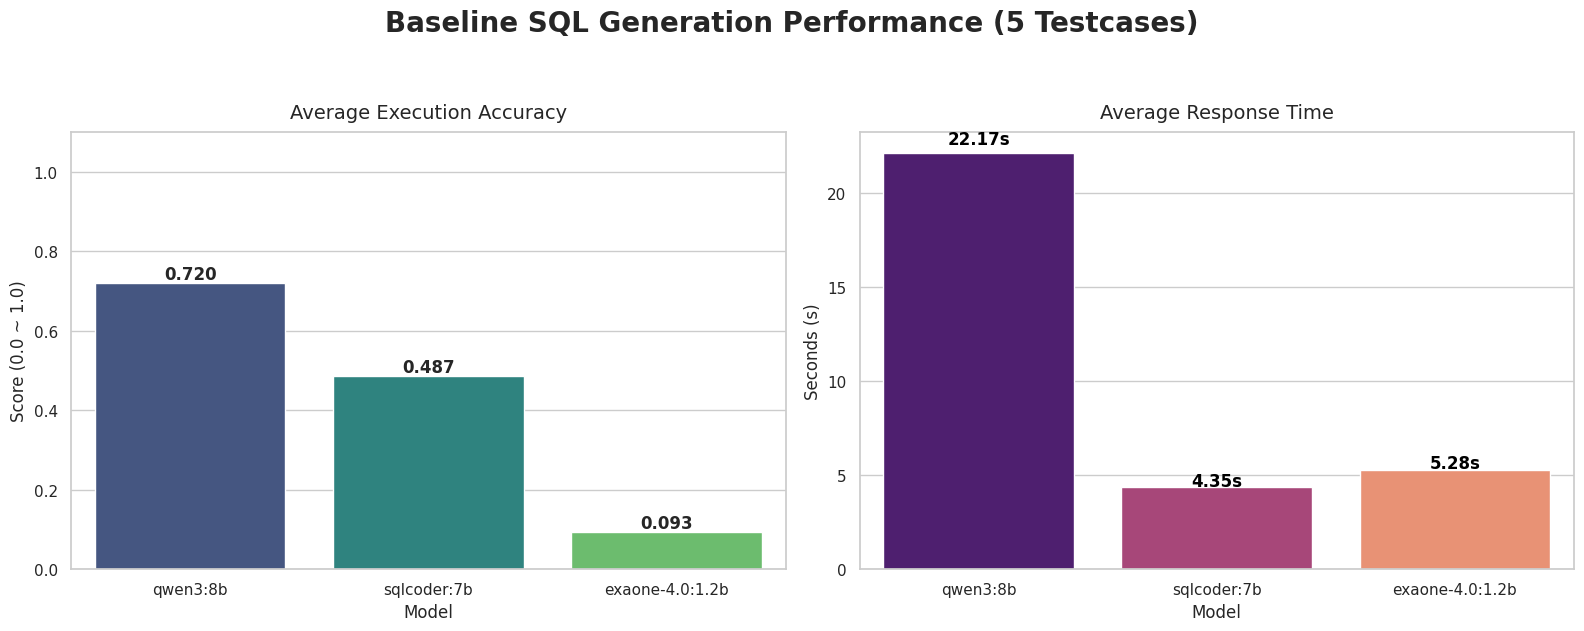

In [31]:

plot_benchmark_results(baseline_results_v1, title="Baseline SQL Generation Performance (5 Testcases)")

In [32]:
baseline_results_v3 = run_benchmark_baseline(gold_set_v3, db)


질문: List the names of all tracks composed by 'Queen'.
-> 기대 SQL: SELECT Name FROM Track WHERE Composer = 'Queen';
--------------------------------------------------------------------------------------------------------------------------------------------
모델명                       | 시간       | 점수     | 생성된 SQL
--------------------------------------------------------------------------------------------------------------------------------------------
qwen3:8b                  | 35.794  s | 0.552  | SELECT Name FROM Track WHERE Composer LIKE '%Queen%' ORDER BY Name LIMIT 10;
sqlcoder:7b               | 0.723   s | 0.186  | SELECT track_name FROM tracks WHERE composer = 'Queen';
exaone-4.0:1.2b           | 14.627  s | 0.0    | A list of Queen's song titles includes: 1. "Bohemian Rhapsody" 2. "We Will Rock You" 3. "Another One Bites the Dust" 4. "Killer Queen" 5. "Don't Stop Me Now" 6. "Radio Ga Ga" 7. "We Are the Champions" 8. "Smells Like Teen Spirit" 9. "Crazy Little Thing Called Love" 1

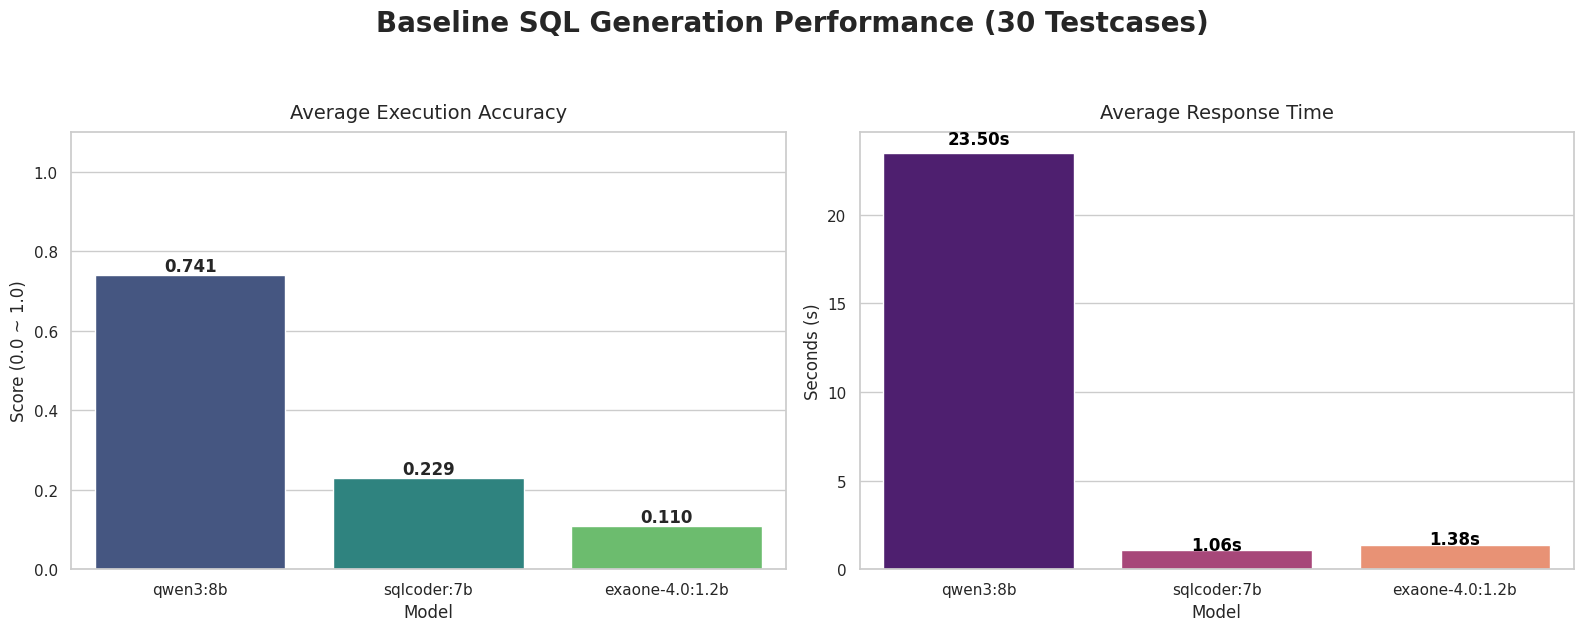

In [33]:
plot_benchmark_results(baseline_results_v3, title="Baseline SQL Generation Performance (30 Testcases)")



### Few-Shot 모델 벤치마크

In [34]:
few_shot_results_v1 = run_benchmark_few_shot(gold_set_v1, db)


질문: List the names of all tracks composed by 'Queen'.
-> 기대 SQL: SELECT Name FROM Track WHERE Composer = 'Queen';
--------------------------------------------------------------------------------------------------------------------------------------------
모델명                       | 시간       | 점수     | 생성된 SQL
--------------------------------------------------------------------------------------------------------------------------------------------
qwen3:8b                  | 62.786  s | 1.0    | SELECT Name FROM Track WHERE Composer = 'Queen';
sqlcoder:7b               | 5.011   s | 0.113  | SELECT t.Name FROM Track t JOIN Artist a ON t.ArtistId = a.ArtistId WHERE a.Name ILIKE '%Queen%';
exaone-4.0:1.2b           | 1.339   s | 1.0    | SELECT Name FROM Track WHERE Composer = 'Queen';

질문: Find the email addresses of all customers who live in 'France'.
-> 기대 SQL: SELECT Email FROM Customer WHERE Country = 'France';
-----------------------------------------------------------------------

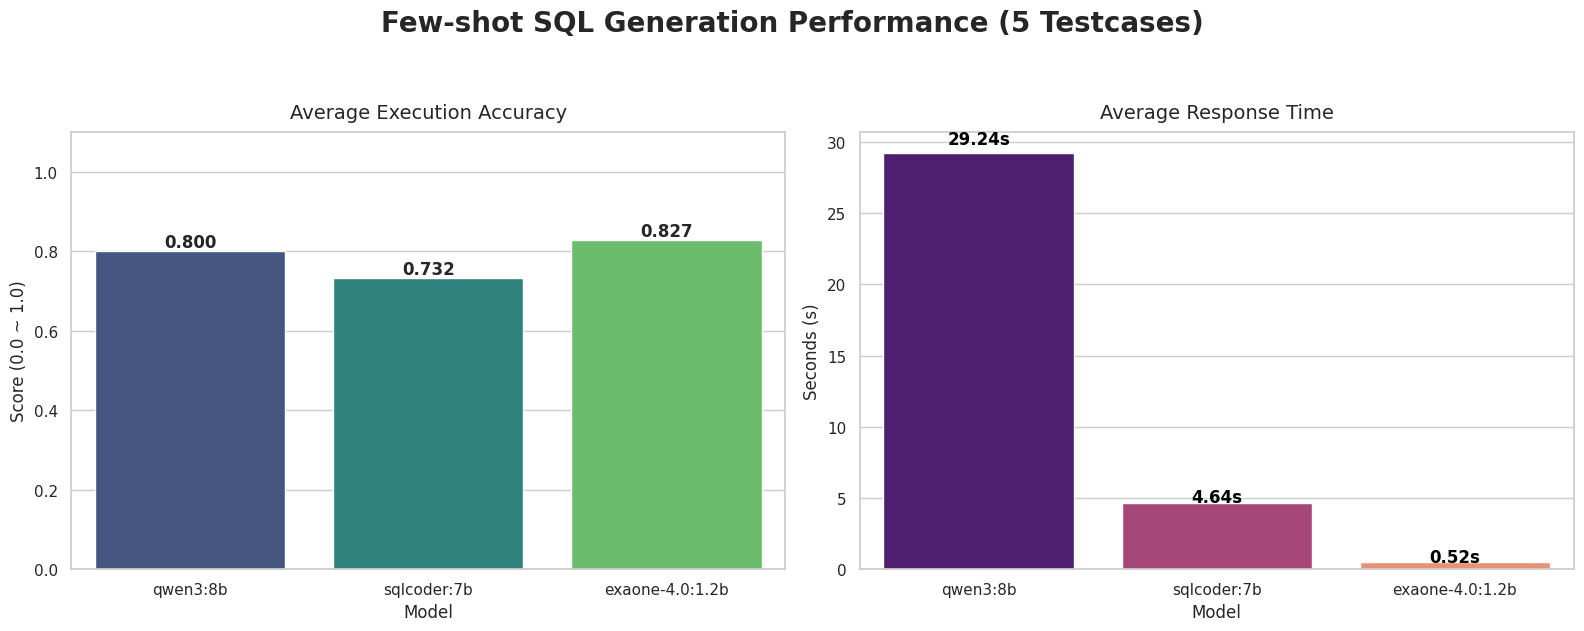

In [35]:
plot_benchmark_results(few_shot_results_v1, title="Few-shot SQL Generation Performance (5 Testcases)")



---



In [36]:
few_shot_results = run_benchmark_few_shot(gold_set_v3, db)


질문: List the names of all tracks composed by 'Queen'.
-> 기대 SQL: SELECT Name FROM Track WHERE Composer = 'Queen';
--------------------------------------------------------------------------------------------------------------------------------------------
모델명                       | 시간       | 점수     | 생성된 SQL
--------------------------------------------------------------------------------------------------------------------------------------------
qwen3:8b                  | 50.066  s | 0.0    | 
sqlcoder:7b               | 4.865   s | 0.131  | SELECT t.Name FROM Track t JOIN Composer c ON t.Composer = c.Name WHERE c.Name = 'Queen';
exaone-4.0:1.2b           | 0.28    s | 1.0    | SELECT Name FROM Track WHERE Composer = 'Queen';

질문: Find the email addresses of all customers who live in 'France'.
-> 기대 SQL: SELECT Email FROM Customer WHERE Country = 'France';
-------------------------------------------------------------------------------------------------------------------------------

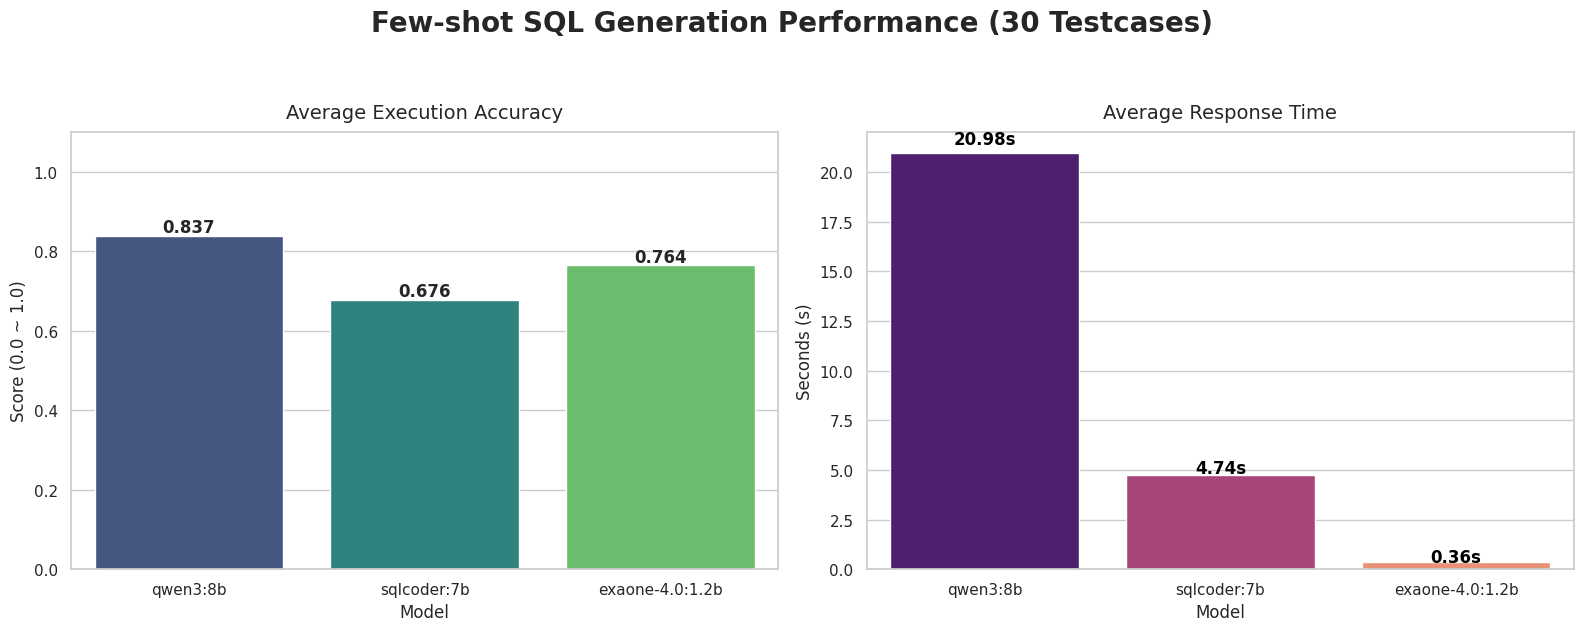

In [37]:
plot_benchmark_results(few_shot_results, title="Few-shot SQL Generation Performance (30 Testcases)")

## Baseline vs Few-shot 모델 결과 비교

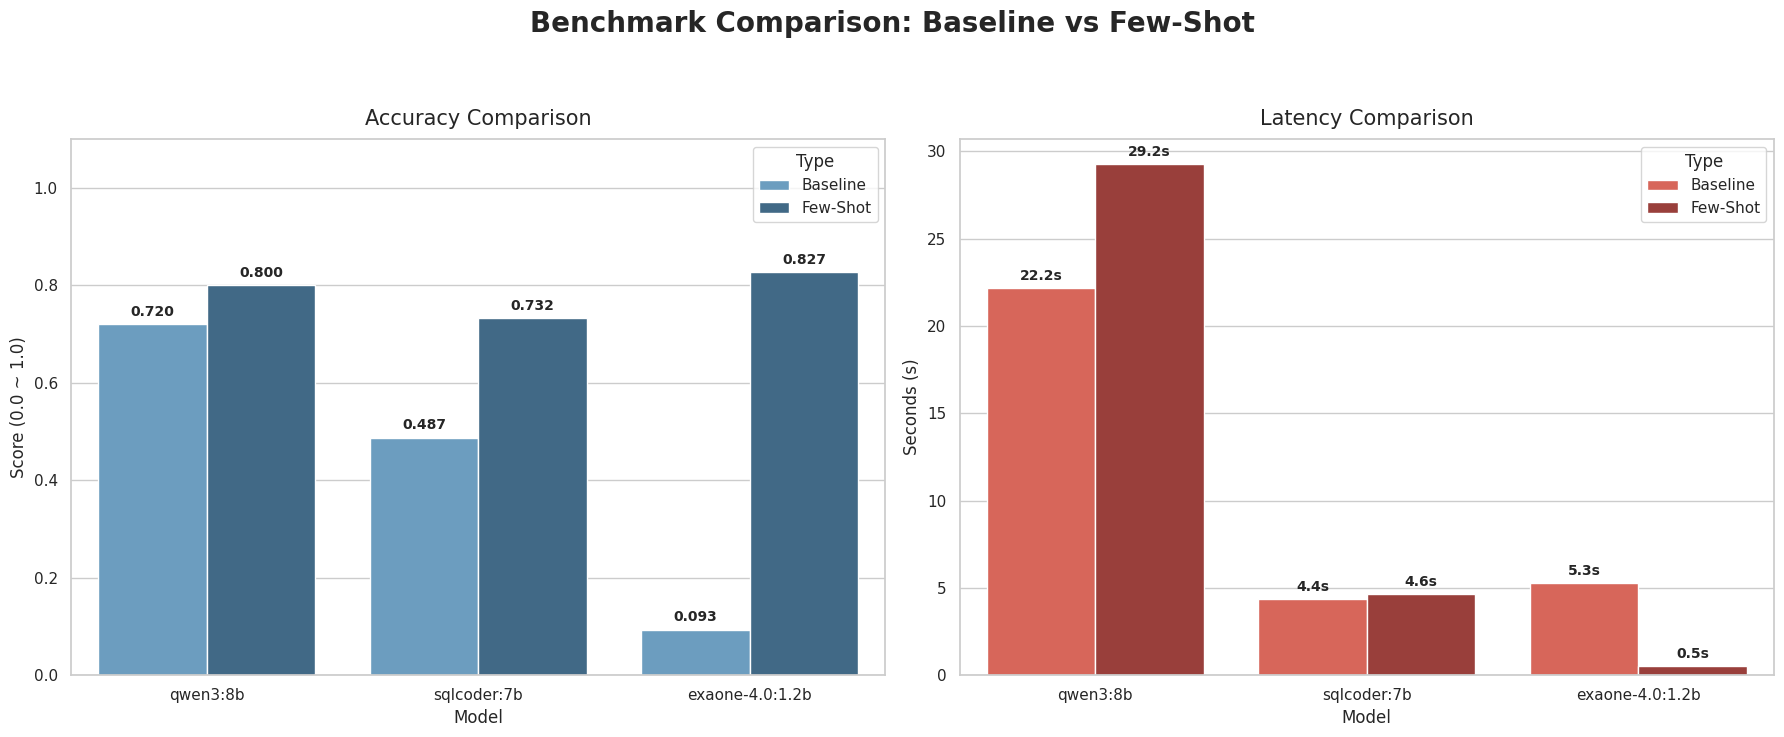

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_combined_benchmark(baseline_scores, few_shot_scores, title="Benchmark Comparison: Baseline vs Few-Shot"):
    """
    Baseline과 Few-Shot 결과를 통합하여 점수와 시간을 비교하는 2개의 플롯을 그립니다.
    """
    data_list = []

    # 1. Baseline 데이터 정리
    for m_name, metrics in baseline_scores.items():
        data_list.append({
            "Model": m_name,
            "Type": "Baseline",
            "Avg Score": round(metrics["score"] / metrics["count"], 3),
            "Avg Time (s)": round(metrics["time"] / metrics["count"], 3)
        })

    # 2. Few-Shot 데이터 정리
    for m_name, metrics in few_shot_scores.items():
        data_list.append({
            "Model": m_name,
            "Type": "Few-Shot",
            "Avg Score": round(metrics["score"] / metrics["count"], 3),
            "Avg Time (s)": round(metrics["time"] / metrics["count"], 3)
        })

    df = pd.DataFrame(data_list)

    # 3. 그래프 설정
    sns.set_theme(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(title, fontsize=20, fontweight='bold', y=1.05)

    # --- 왼쪽 플롯: 평균 점수 비교 (Accuracy) ---
    sns.barplot(
        x="Model", y="Avg Score", hue="Type", data=df,
        ax=ax1, palette="Blues_d"
    )
    ax1.set_title("Accuracy Comparison", fontsize=15, pad=10)
    ax1.set_ylabel("Score (0.0 ~ 1.0)")
    ax1.set_ylim(0, 1.1)

    # 수치 표시 (점수)
    for p in ax1.patches:
        if p.get_height() > 0:
            ax1.annotate(f'{p.get_height():.3f}',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=10,
                         fontweight='bold', xytext=(0, 9),
                         textcoords='offset points')

    # --- 오른쪽 플롯: 평균 시간 비교 (Latency) ---
    sns.barplot(
        x="Model", y="Avg Time (s)", hue="Type", data=df,
        ax=ax2, palette="Reds_d"
    )
    ax2.set_title("Latency Comparison", fontsize=15, pad=10)
    ax2.set_ylabel("Seconds (s)")

    # 수치 표시 (시간)
    for p in ax2.patches:
        if p.get_height() > 0:
            ax2.annotate(f'{p.get_height():.1f}s',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=10,
                         fontweight='bold', xytext=(0, 9),
                         textcoords='offset points')

    plt.tight_layout()
    plt.show()

# --- 실행 방법 ---
# baseline_results_v1 = run_benchmark_baseline(gold_set_v1, db)
# few_shot_results_v1 = run_benchmark_few_shot(gold_set_v1, db)
plot_combined_benchmark(baseline_results_v1, few_shot_results_v1)

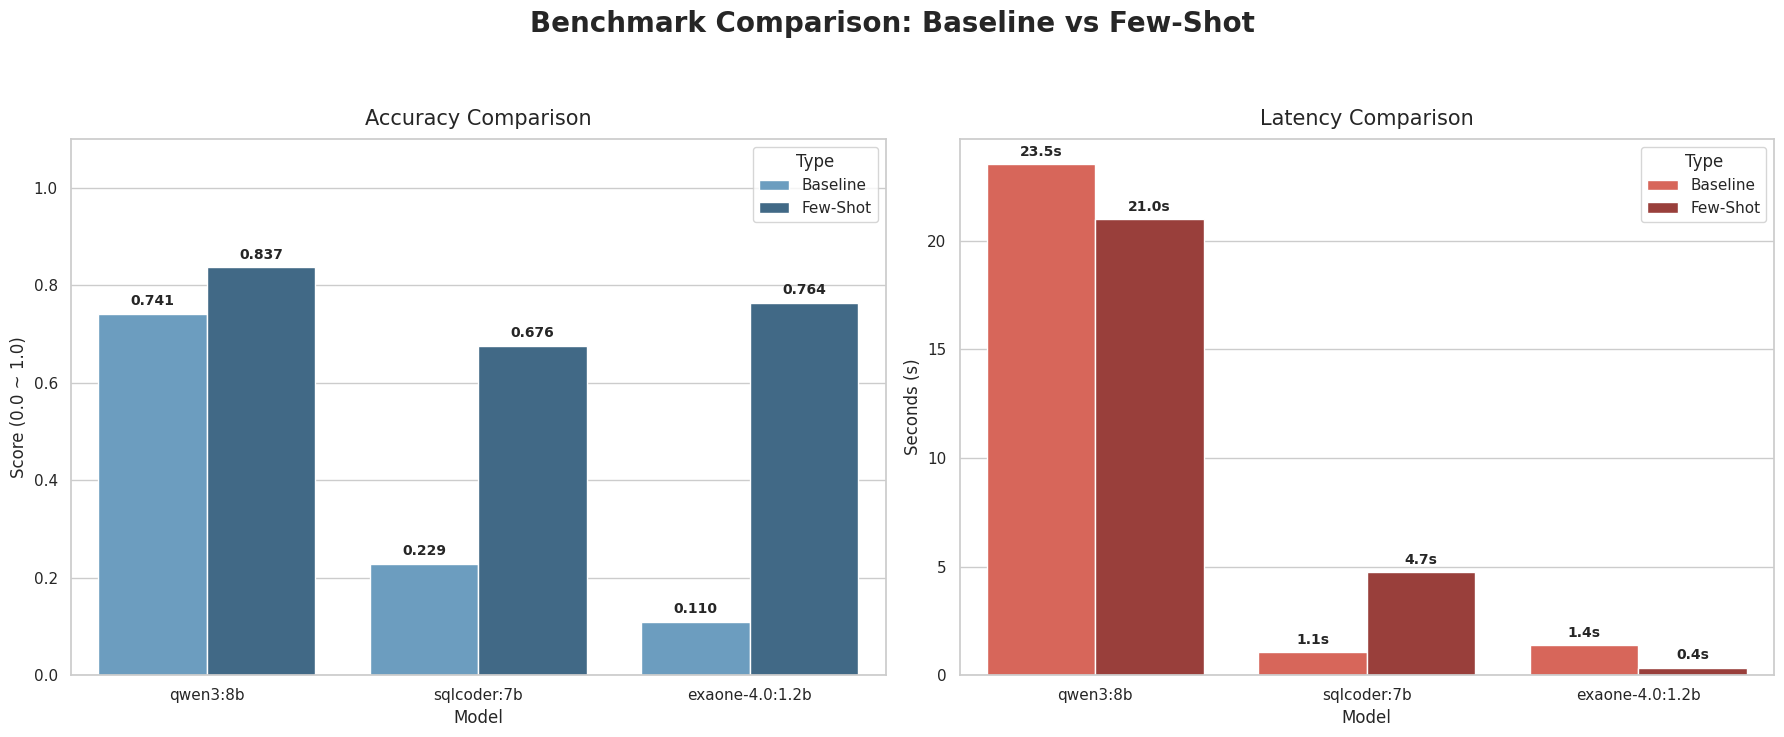

In [39]:
plot_combined_benchmark(baseline_results_v3, few_shot_results)